In [63]:
import pandas_montecarlo
import pandas as pd
from __future__ import division
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture

from sklearn.feature_selection import SelectKBest

In [2]:
pnl = yf.download(['MSFT'],start='2017-01-01',end='2017-12-31')

[*********************100%***********************]  1 of 1 downloaded


In [97]:
X = pnl[['Adj Close']].pct_change().fillna(0)
X.head()

,Adj Close
Date,
2017-01-03,0.000000
2017-01-04,-0.004474
2017-01-05,0.000000
2017-01-06,0.008668
2017-01-09,-0.003183


In [98]:
mc = X['Adj Close'].montecarlo(sims=1000, bust=-0.1, goal=1)

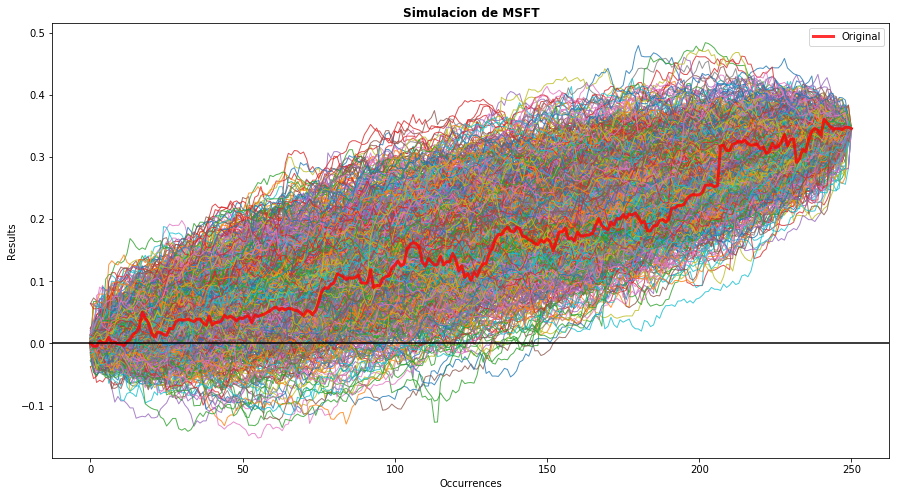

In [99]:
mc.plot(figsize=(15, 8),title='Simulacion de MSFT')

In [100]:
mc.data.head()

,original,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.001431,0.008895,-0.003908,0.015264,0.001805,0.007486,0.002757,0.002065,0.000955,...,0.015034,0.008053,0.003320,0.015034,-0.000142,0.012979,0.013521,-0.000628,0.006424,-0.016551
1,-0.004474,-0.000869,0.020245,0.012979,-0.000761,-0.005794,-0.005379,0.007072,0.003507,0.006487,...,0.005279,0.003320,-0.005265,-0.004474,0.001431,0.003441,0.008714,0.023681,0.003360,0.003408
2,0.000000,-0.004655,-0.003612,0.003666,-0.002368,0.004040,-0.004463,0.014585,0.007072,0.020135,...,0.000000,-0.008463,0.020245,0.012468,-0.004463,-0.004000,0.015005,-0.001070,0.008525,-0.011101
3,0.008668,0.003666,0.000258,-0.007733,-0.005794,0.020245,0.002761,0.000311,0.001243,-0.018143,...,0.000117,-0.007383,0.014585,-0.001522,-0.005794,0.008525,0.006487,-0.002587,-0.002917,-0.009882
4,-0.003183,0.005387,-0.004463,-0.018715,0.012807,0.001310,-0.004655,0.003630,-0.000869,0.004874,...,0.001847,-0.003892,0.003630,0.000000,-0.006367,0.003666,-0.015455,-0.004655,-0.011101,0.000000


In [101]:
def prec(y):
    p = [100]
    for x in range(len(y)):
        p.append(p[-1]*(1+y[x]))
    return p

In [102]:
y = np.array([prec(mc.data[i]) for i in mc.data.columns])

In [109]:
X = pd.DataFrame(columns=mc.data.columns)
for x in mc.data.columns:
    X[x]=prec(mc.data[x])

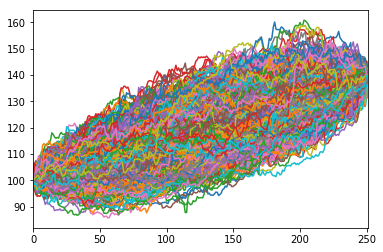

In [104]:
X.plot(legend=False)

In [110]:
mm1 = MinMaxScaler()
mm1.fit(X)
Xm = pd.DataFrame(mm1.transform(X),columns=X.columns)

In [111]:
Xm.head()

,original,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.010571,0.034358,0.000000,0.066903,0.000000,0.078731,0.009530,0.023958,0.000000,0.000000,...,0.000000,0.019290,0.017510,0.000000,0.103295,0.029248,0.000000,0.078920,0.000000,0.078182
1,0.010571,0.037834,0.020487,0.057905,0.038026,0.082795,0.026094,0.030442,0.005022,0.002070,...,0.029379,0.037701,0.025305,0.037581,0.102974,0.058287,0.025360,0.077464,0.013498,0.039894
2,0.000000,0.035719,0.067533,0.087668,0.036102,0.069725,0.014104,0.047120,0.013568,0.016151,...,0.039849,0.045353,0.012902,0.026229,0.106202,0.066087,0.041924,0.132314,0.020603,0.047648
3,0.000000,0.024401,0.058970,0.096183,0.030118,0.078786,0.004209,0.081757,0.030865,0.060142,...,0.039849,0.025784,0.060339,0.057721,0.096119,0.056989,0.070696,0.129777,0.038690,0.022308
4,0.020386,0.033272,0.059579,0.078155,0.015510,0.124378,0.010303,0.082507,0.033926,0.019705,...,0.040082,0.008858,0.095207,0.053828,0.083088,0.076299,0.083321,0.123650,0.032449,0.000000


In [112]:
def dias(X):
    y = 0
    for i in range(1,len(X)):
        if (X[i-1]< X[i]):
            y = y + 1     
    return y
def ren(X):
    y = []
    for i in range(1,len(X)):
        y.append((X[i]-X[i-1])/X[i-1])   
    return np.mean(y)

d = []
r = []
for col in Xm.columns:
    d.append(dias(Xm[col]))
    r.append(ren(X[col]))

In [113]:
W = pd.DataFrame(columns=X.columns)
W = W.T
W['Media'] = Xm.mean()
W['Std'] = Xm.std()
W['Dias'] = d
W['r'] = r

In [114]:
W.head()

,Media,Std,Dias,r
original,0.397491,0.285359,137,0.001377
1,0.630097,0.269352,137,0.001377
2,0.454414,0.244183,137,0.001377
3,0.430805,0.252848,137,0.001377
4,0.421507,0.293158,137,0.001377


In [115]:
sc = pickle.load(open('pipe_sc.m','rb'))
mm = pickle.load(open('pipe_mm.m','rb'))
pca = pickle.load(open('pipe_pca.m','rb'))
mds = pickle.load(open('pipe_mds.m','rb'))

In [116]:
Ws = pd.DataFrame(sc.transform(W),columns=W.columns)
Wmm = pd.DataFrame(mm.transform(W),columns=W.columns)

In [117]:
pca = PCA(n_components=2)
pca.fit(Ws)
Wp = pd.DataFrame(pca.transform(Ws),columns=['p1','p2'])

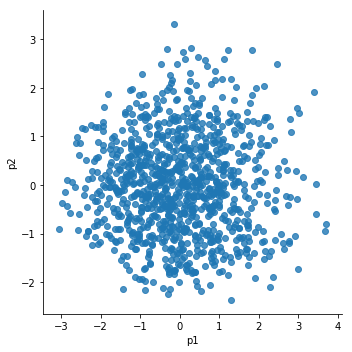

In [118]:
sns.lmplot(data=Wp,x='p1',y='p2',fit_reg=False)

In [119]:
cl = pickle.load(open('cluster.m','rb'))

In [120]:
Wp['cl']=Wmm['cl'] =Wp['cl'] =W['cl']= cl.predict(Wmm)

Text(0.5,1,u'Cluster de las simulaciones de MSFT')

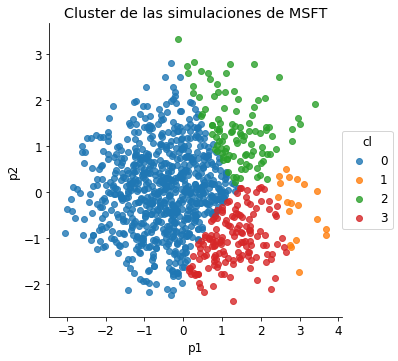

In [149]:
sns.lmplot(data=Wp,x='p1',y='p2',hue='cl',fit_reg=False)
ax = plt.gca()
ax.set_title("Cluster de las simulaciones de MSFT")

In [150]:
Wp.head()

,p1,p2,cl
0,-0.025247,-0.915027,0
1,-0.438176,1.900864,0
2,1.083011,0.202536,0
3,0.896439,-0.164224,0
4,-0.374659,-0.732992,0


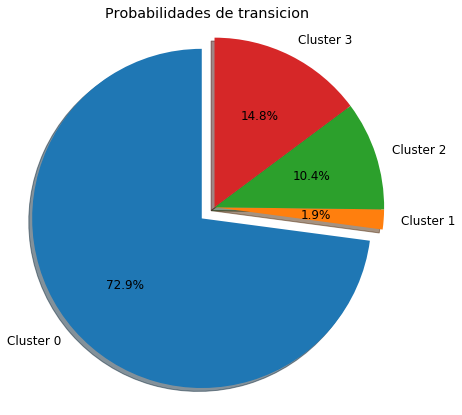

In [145]:
labels = 'Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'
sizes = [0.729, 0.019,0.104, 0.148]
explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
plt.rcParams['font.size'] = 12
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Probabilidades de transicion')
plt.show()